# Exercise 1 d)
 Import the libraries that we'll use

In [1]:
from numpy  import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML, display_pretty
from networkx.algorithms.community import LFR_benchmark_graph
np.random.seed(101)

# Read graph from file and apply transformations
def read_graph(inputFile):
    # To read the network from a file, we use the command read_edgelist.
    G= nx.read_edgelist(inputFile, comments='%', nodetype=int, data=(('weight',float),))
    # We transfor the network into the undirected version.
    G = G.to_undirected()
    # Here we consider only the largest component.
    Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    G=Gcc[0]
    # Sometimes the node labels are not in the sequential order or strings are used. To facilitate our implementation, let us convert the labels to integers starting with the index zero, because Python uses 0-based indexing.
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    # Save graph to the network
    return G

# Read graph from file and apply transformations
def read_graphCElegans(inputFile):
    # To read the network from a file, we use the command read_edgelist.
    G= nx.read_edgelist(inputFile, comments='#', nodetype=str, data=(('weight',float),))
    # We transfor the network into the undirected version.
    G = G.to_undirected()
    # Here we consider only the largest component.
    Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    G=Gcc[0]
    # Sometimes the node labels are not in the sequential order or strings are used. To facilitate our implementation, let us convert the labels to integers starting with the index zero, because Python uses 0-based indexing.
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    # Save graph to the network
    return G

# Read graph from file and apply transformations
def read_graphCsv(inputFile):
    # To read the network from a file, we use the command read_edgelist.
    G= nx.read_edgelist(inputFile, comments='#', delimiter=',', nodetype=str, data=(('weight',float),))
    # We transfor the network into the undirected version.
    G = G.to_undirected()
    # Here we consider only the largest component.
    Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    G=Gcc[0]
    # Sometimes the node labels are not in the sequential order or strings are used. To facilitate our implementation, let us convert the labels to integers starting with the index zero, because Python uses 0-based indexing.
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    # Save graph to the network
    return G

## Benchmark function

In [2]:
# Generate a graph for girvan newman benchmark
def benchmark_girvan_newman(N, mu):
    #N = 128
    tau1 = 3
    tau2 = 1.5
    #mu = 0.04
    k =16
    minc = 32
    maxc = 32
    return LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k,
                            max_degree = k, min_community=minc, max_community = maxc, seed = 42)

Write all the functions that we'll need

 For failure simulation

In [3]:
def failures(H):
    '''
     Simulate failures in the graph H.
     Return S = list with size of largest component. This is a fraction of the total
     number of nodes
     Return vn = list with fraction of removed nodes
    '''

    G = H.copy()
    from random import choice
    N0 = len(G)
    minComponentSize = int(0.01*N0)
    if minComponentSize < 1:
        minComponentSize = 1
    vn = []
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > minComponentSize):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = random.choice(G.nodes()) #select the node on the largest component
        #print('selected to removed:', node)
        G.remove_node(node)
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0]
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)

    return S, vn

def most_connected(G): # This function is used to find the most connected node
    maxk = 0
    node = 0
    for i in G.nodes():
        if(G.degree(i) >= maxk):
            maxk = G.degree(i)
            node = i
    return node

For attack simulation

In [4]:
def attacks(H):
    '''
     Simulate attacks in the graph H.
     Return S = list with size of largest component. This is a fraction of the total
     number of nodes
     Return vn = list with fraction of removed nodes
    '''
    G = H.copy()
    from random import choice
    N0 = len(G)
    minComponentSize = int(0.01*N0)
    if minComponentSize < 1:
        minComponentSize = 1
    vn = []
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > minComponentSize):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = most_connected(G) #select the most connected node on the largest component
        #print('selected to removed:', node)
        G.remove_node(node)
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0]
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn


def fcritical(G):
    '''
        Calculate critical fraction of nodes that needs to be removed in order to
        break an heterogeneous network G.
    '''
    def momment_of_degree_distribution2(G,m):
        M = 0
        N = len(G)
        for i in G.nodes():
            M = M + G.degree(i)**m
        M = M/N
        return M
    f = 1 - 1/(momment_of_degree_distribution2(G,2)/momment_of_degree_distribution2(G,1) - 1)
    return f

Here is the action

In [5]:
def main():
    nNodes = 128
    # Create a list with the networks
    networks = []
    networks.append(benchmark_girvan_newman(nNodes, 0.1))
    networks[-1].name = 'mu = 0.1'
    networks.append(benchmark_girvan_newman(nNodes, 0.3))
    networks[-1].name = 'mu = 0.3'
    networks.append(benchmark_girvan_newman(nNodes, 0.5))
    networks[-1].name = 'mu = 0.5'

    # Calculate the response to failures of all the networks inside list networks
    results = []
    currentNetworkSimulations = []
    nSimulations = 1
    removedNodes = None
    for i in range(len(networks)):
        # Do simulations and append them to currentNetworkSimulations
        for j in range(nSimulations):
            if (i == 0) and (j == 0):
                componentSize, removedNodes = failures(networks[i])
            else:
                componentSize, _ = failures(networks[i])
            currentNetworkSimulations.append(componentSize)


        # Calculate the average of the simulations
        averageOfSimulations = []
        for j in range(len(currentNetworkSimulations[0])):
            partialSum = 0
            for simulation in currentNetworkSimulations:
                partialSum += simulation[j]
            #print(partialSum/len(currentNetworkSimulations))
            averageOfSimulations.append(partialSum/len(currentNetworkSimulations))

        # Append averageOfSimulations to results
        results.append(averageOfSimulations)

        # Clear list
        currentNetworkSimulations.clear()

    # Plot failure simulation
    plt.figure()
    # Plot all results of simulation
    for i in range(len(results)):
        plt.plot(removedNodes, results[i], '-o', label=networks[i].name)
    plt.title('Failure Comparison')
    plt.legend()
    plt.xlabel("f", fontsize=20)
    plt.ylabel("S", fontsize=20)
    plt.grid(True)
    # Save figure
    plt.savefig('lastPlotEx1cFailure.png')
    plt.show(block=True);

    # Calculate the response to attacks of all the networks inside list networks
    results = []
    currentNetworkSimulations = []
    nSimulations = 1
    removedNodes = None
    for i in range(len(networks)):
        # Do simulations and append them to currentNetworkSimulations
        for j in range(nSimulations):
            if (i == 0) and (j == 0):
                componentSize, removedNodes = attacks(networks[i])
            else:
                componentSize, _ = attacks(networks[i])
            currentNetworkSimulations.append(componentSize)


        # Calculate the average of the simulations
        averageOfSimulations = []
        for j in range(len(currentNetworkSimulations[0])):
            partialSum = 0
            for simulation in currentNetworkSimulations:
                partialSum += simulation[j]
            #print(partialSum/len(currentNetworkSimulations))
            averageOfSimulations.append(partialSum/len(currentNetworkSimulations))

        # Append averageOfSimulations to results
        results.append(averageOfSimulations)

        # Clear list
        currentNetworkSimulations.clear()

    # Plot attack simulation
    plt.figure()
    # Plot all results of simulation
    for i in range(len(results)):
        plt.plot(removedNodes, results[i], '-o', label=networks[i].name)
    plt.title('Attack Comparison')
    plt.legend()
    plt.xlabel("f", fontsize=20)
    plt.ylabel("S", fontsize=20)
    plt.grid(True)
    # Save figure
    plt.savefig('lastPlotEx1cAttack.png')
    plt.show(block=True);

Call main

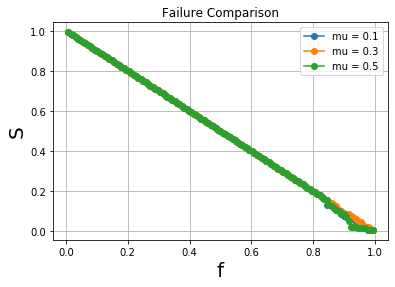

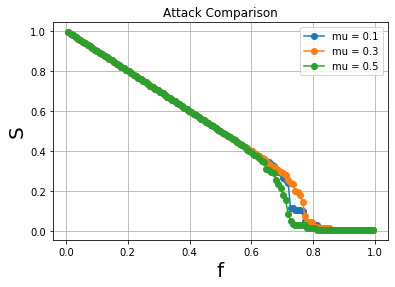

In [6]:
if __name__ == "__main__":
    main()

Analyzing the charts we cannot see relevant difference among the robustness of the different networks against attacks or failure. So, considering our experiment, we can say that in that case, the existance of communities didn't affect robustness considerably.